# Loss Landscape
In this notebook we plot the loss landscape of the models to see how it is efffected by the quantization and see the correlation between some metrics and the robustnmess of the model.

In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from pylab import *
import os
import pickle
import pandas as pd
import numpy as np
from paretoset import paretoset

import loss_landscapes
import loss_landscapes.metrics


Build the dataset by merging all the analysis

In [2]:
df_noise = pd.read_csv('./results/econ/noise.csv')
df_cka = pd.read_csv('./results/econ/cka.csv')
df_fisher = pd.read_csv('./results/econ/fisher.csv')
df_neural_efficiency = pd.read_csv('./results/econ/neural_efficiency.csv')

In [3]:
df_cka = df_cka[['precision', 'batch_size', 'learning_rate', 'avg_cka']]
df_fisher = df_fisher[['precision', 'batch_size', 'learning_rate', 'avg_EF']]
df_neural_efficiency = df_neural_efficiency[['precision', 'batch_size', 'learning_rate', 'net_efficiency']]
dataset_df = pd.merge(df_noise, df_cka, on=['precision', 'batch_size', 'learning_rate'])
dataset_df = pd.merge(dataset_df, df_fisher, on=['precision', 'batch_size', 'learning_rate'])
dataset_df = pd.merge(dataset_df, df_neural_efficiency, on=['precision', 'batch_size', 'learning_rate'])
dataset_df.head()

precision        emd   noise 5%  noise 10%  noise 15%  noise 20%  \
0          2  13.756807  13.756808  13.756808  13.756808  13.756808   
1          2  13.756807  13.756729  13.755988  13.755217  13.754984   
2          2   7.678294   3.553595   3.553208   3.553208   3.553208   
3          2   3.553219   3.562033   3.562685   3.562895   3.563481   
4          2   3.189357   3.169098   3.287215   3.410858   3.507693   

   batch_size  learning_rate   avg_cka    avg_EF  net_efficiency  
0          16        0.10000  0.000000  0.000000        0.005529  
1          16        0.05000  0.277319  0.000000        0.049456  
2          16        0.02500  0.215985  0.000000        0.005970  
3          16        0.01250  0.007814  0.000000        0.003023  
4          16        0.00625  0.255932  0.000017        0.115388

In [4]:
dataset_df.to_csv('./results/econ/dataset.csv', index=False)
# dataset_df = dataset_df[~dataset_df['precision'].isin([2])]

# Correlation between robustness and metrics

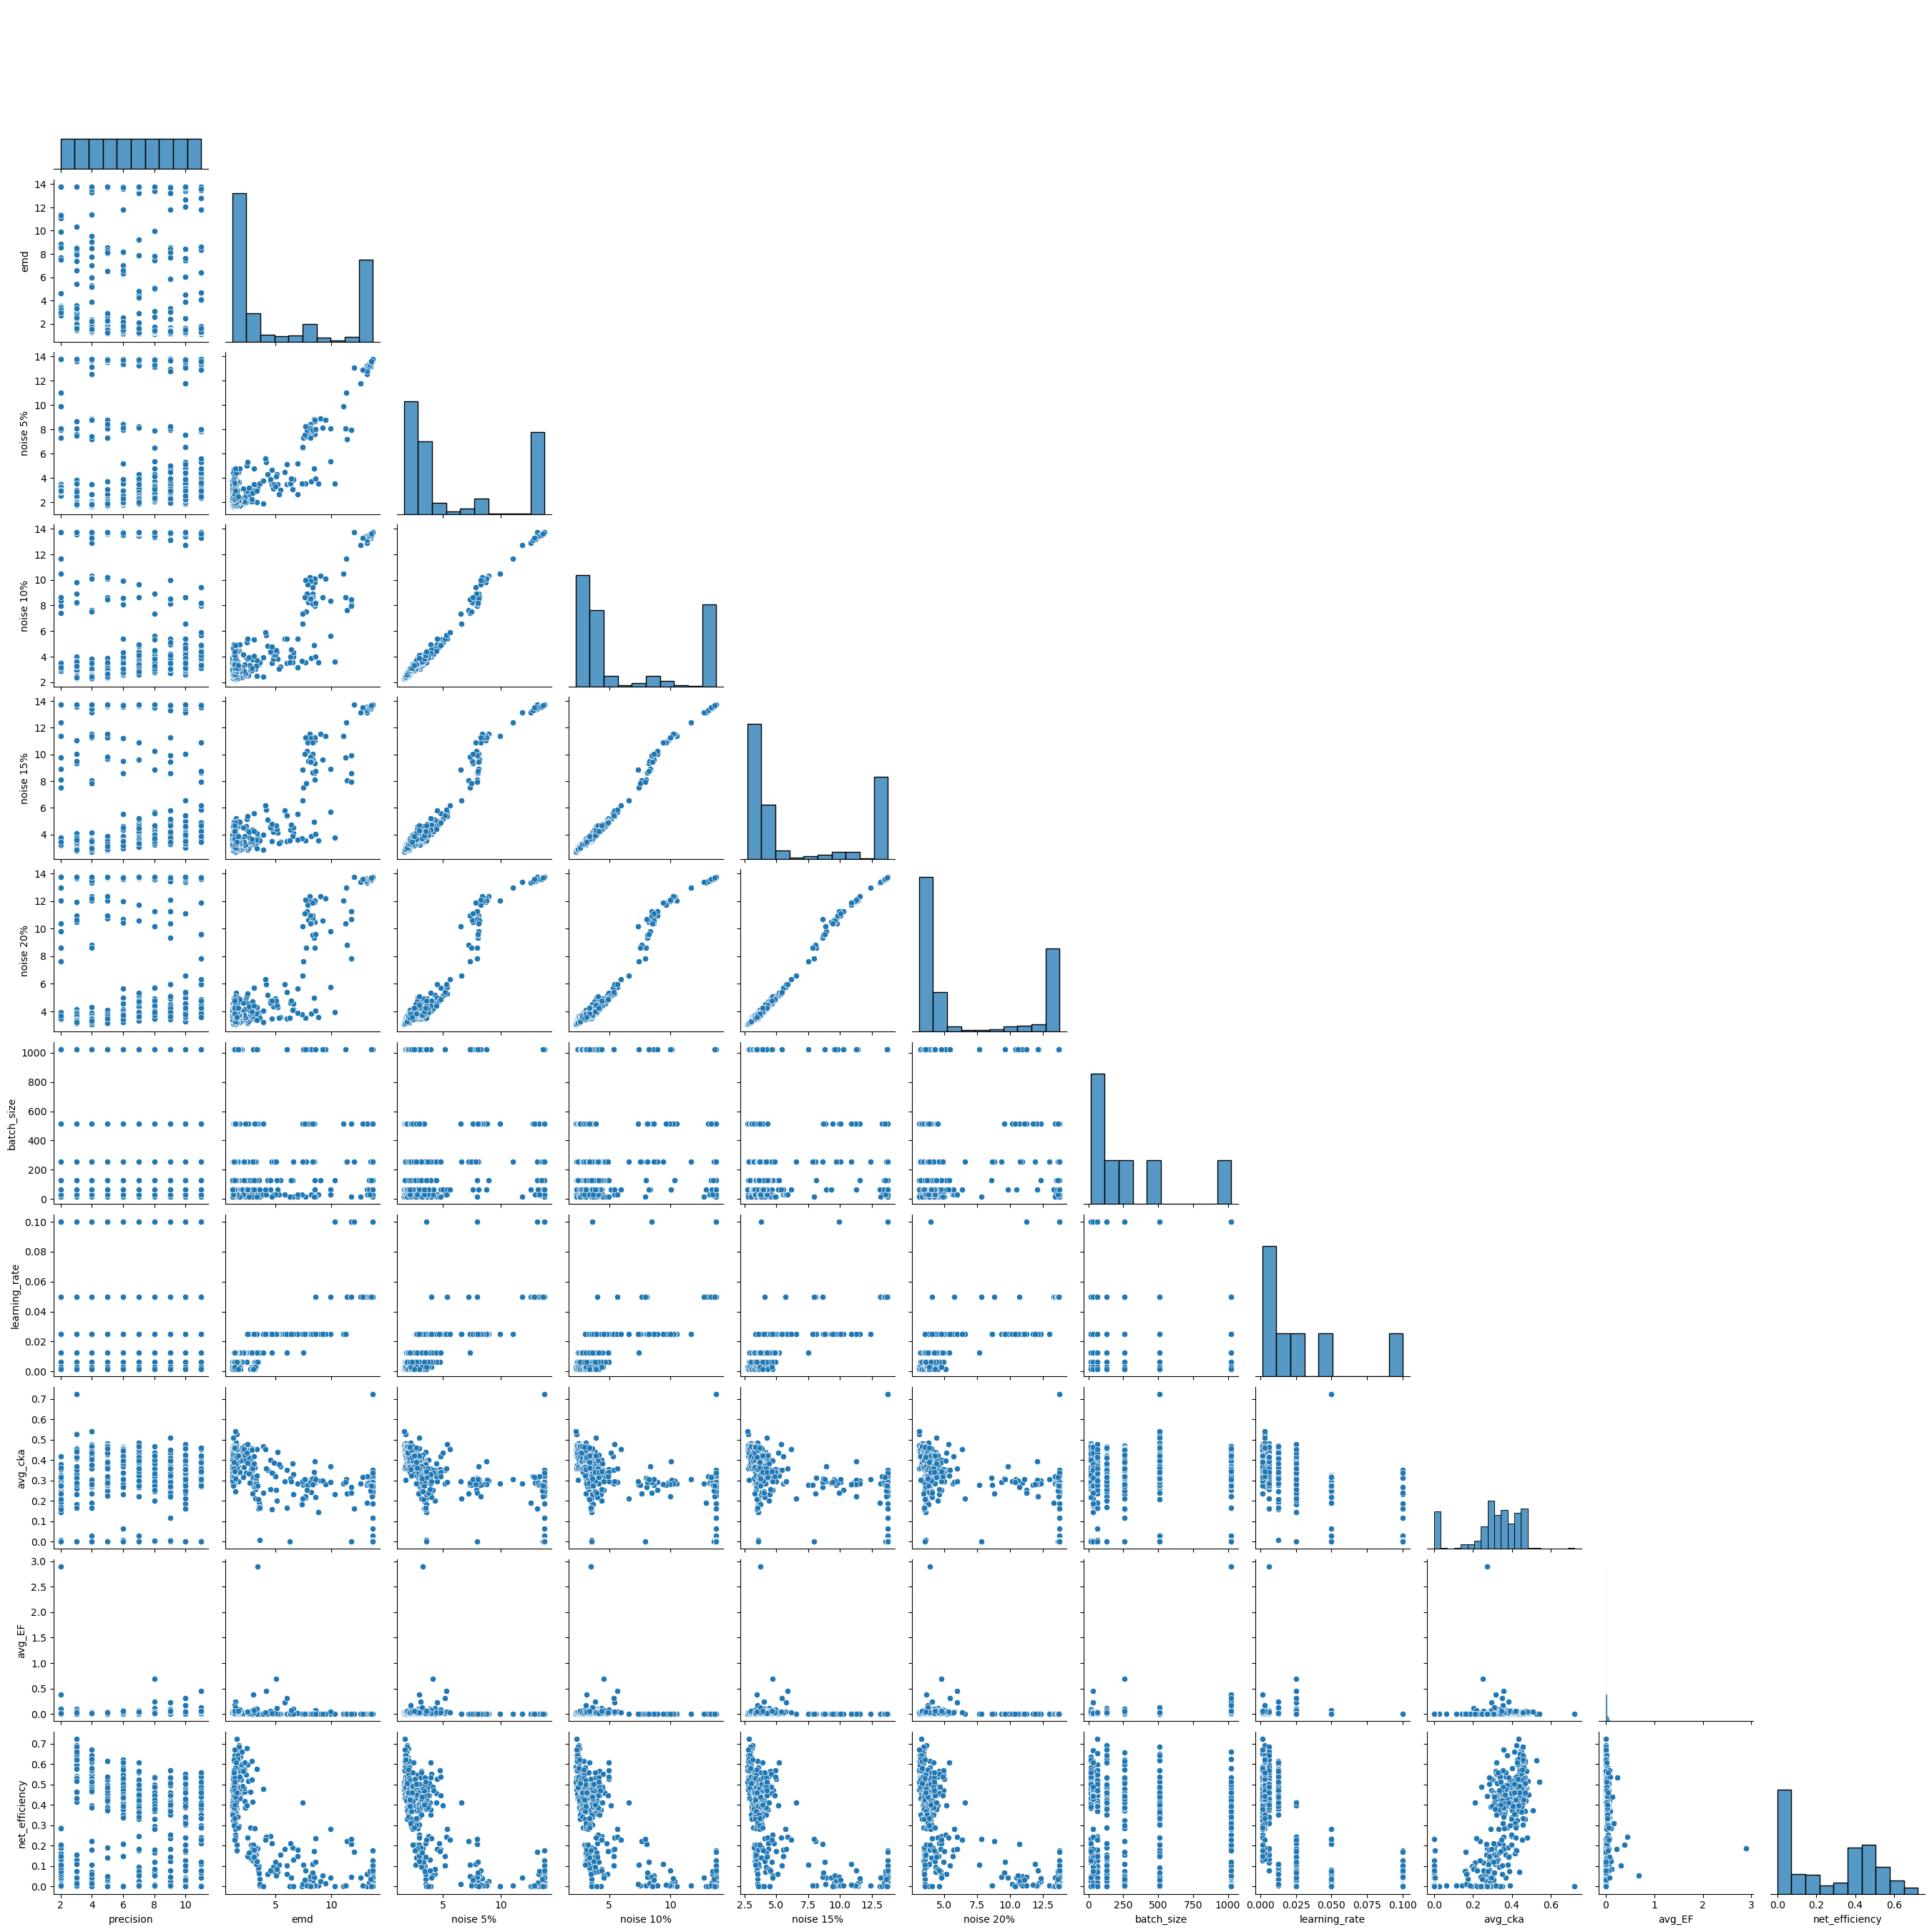

In [5]:
# dataset_df.drop(columns=['noise 10%', 'noise 15%', 'noise 20%'], inplace=True)
sns.pairplot(dataset_df, corner=True)
plt.show()

In [6]:
correlation_matrix = dataset_df.corr()

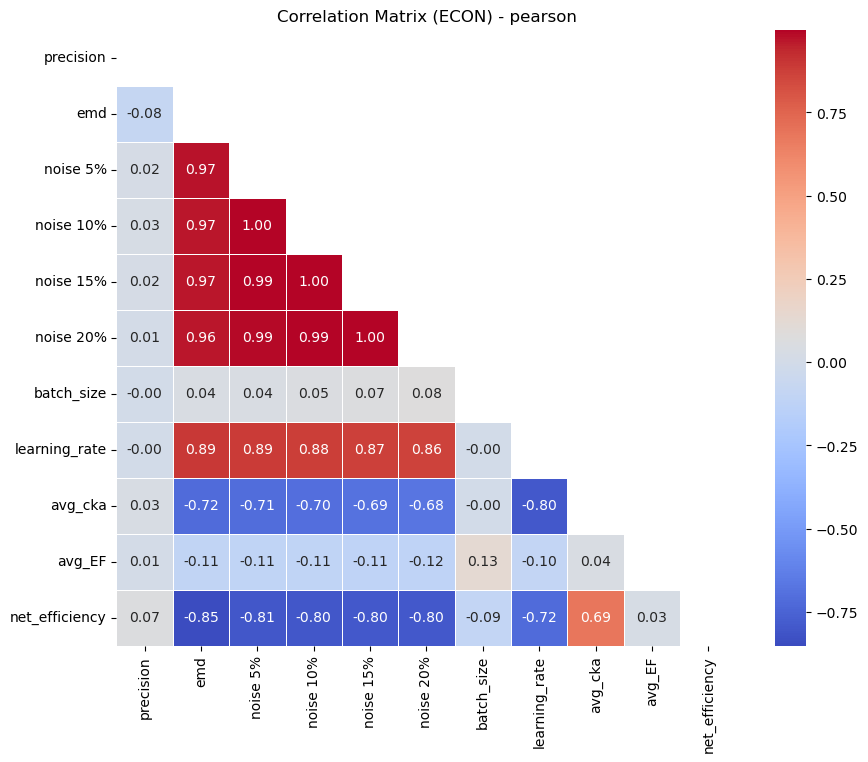

In [7]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix (ECON) - pearson')
plt.show()

Check the logarithmic correlation:

In [8]:
correlation_matrix = dataset_df.corr(method='spearman')

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# plt.title('Correlation Matrix (ECON) - spearman')
# plt.show()

In [9]:
correlation_matrix = dataset_df.corr(method='kendall')

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# plt.title('Correlation Matrix (ECON) - kendall')
# plt.show()

# Effect of the quantization on the loss landscapes

In [10]:
DATA_PATH = '/home/jovyan/checkpoint/'

In [11]:
def get_loss_landscapes(batch_size, 
                        learning_rate, 
                        precision,
                        size, 
                        normalization,
                        steps, 
                        distance):
    '''
    Get the value of the Neural Efficiency
    '''
    # path to the directory
    path = os.path.join(
        DATA_PATH, 
        f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/',
        f'plot_{normalization}_{steps}_{distance}.pkl'
    )
    try:
        f = open(path, "rb")
        data = pickle.load(f)
        f.close()
    except:
        print(path + ' Not found!')
        return False
    
    return data[f'plot_{normalization}_{steps}_{distance}']
    

In [12]:
BATCH_SIZE = 512
LEARNING_RATE = 0.003125
NORMALIZATION = 'filter'
STEPS = 200
DISTANCE = 150
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

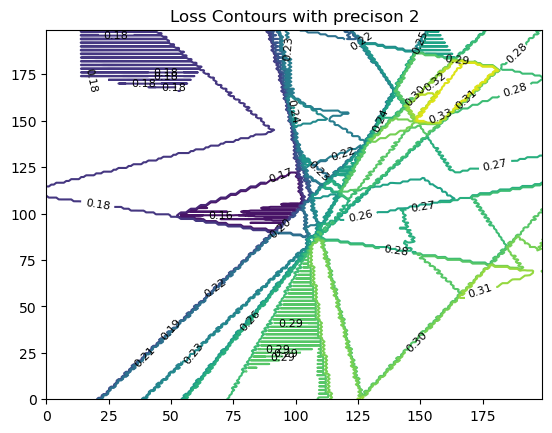

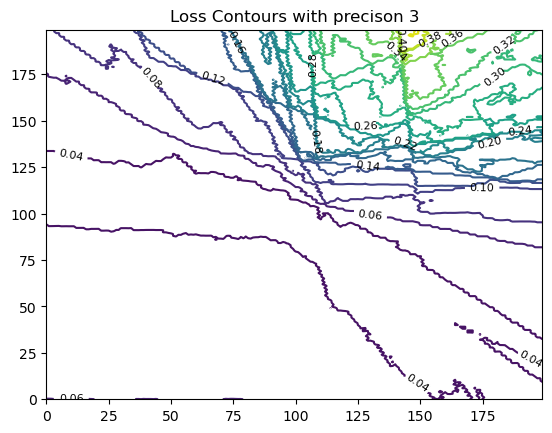

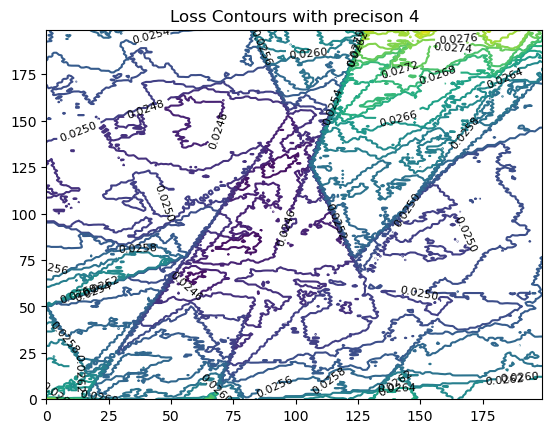

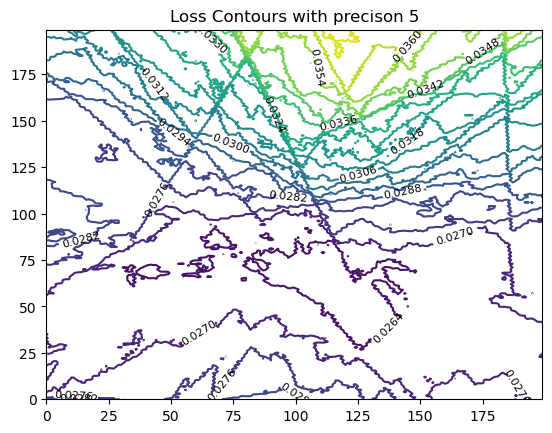

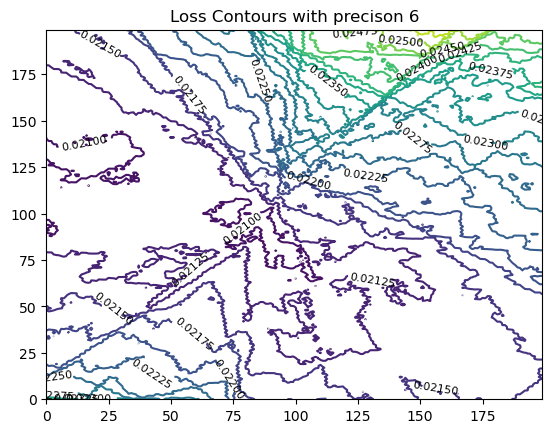

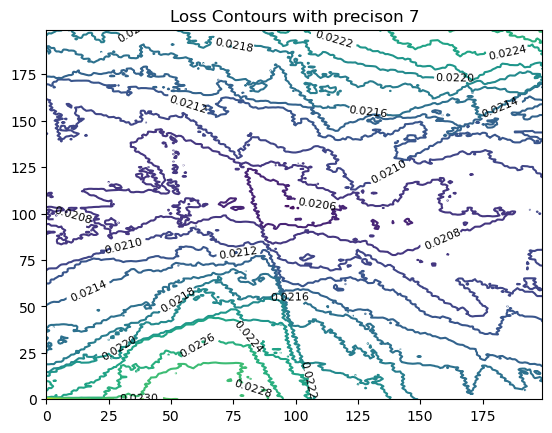

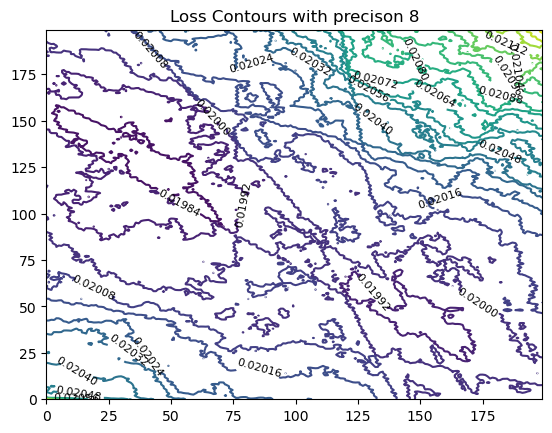

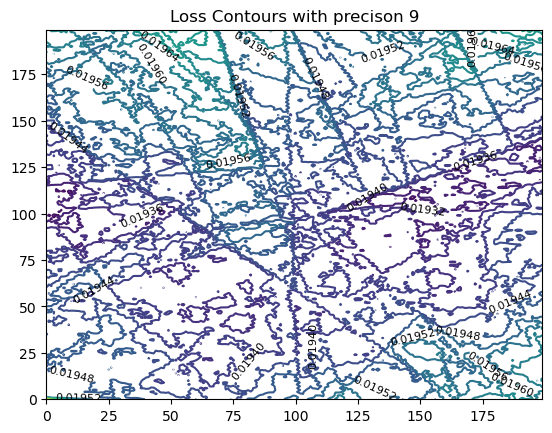

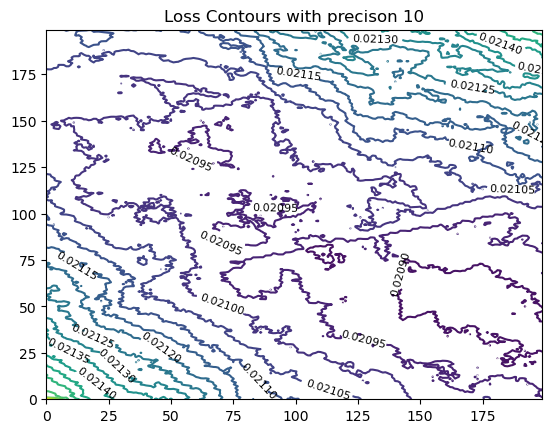

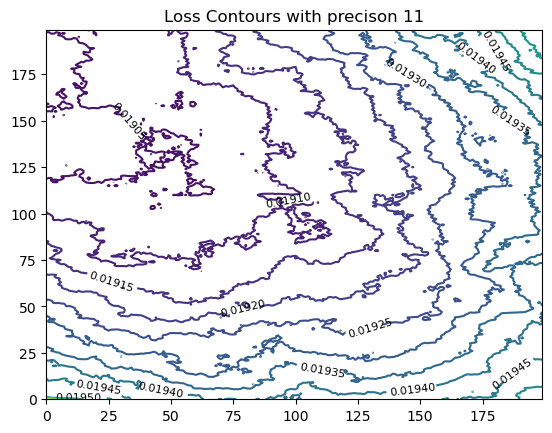

In [13]:
for p in precisions:
    data = get_loss_landscapes(BATCH_SIZE, LEARNING_RATE, p, 'baseline', NORMALIZATION, STEPS, DISTANCE)
    loss_data = data['points']
    # plot 2D
    plot = plt.contour(loss_data, levels=20)
    plt.clabel(plot, inline=True, fontsize=8, colors='black')
    plt.title(f'Loss Contours with precison {p}')
    plt.show()
    


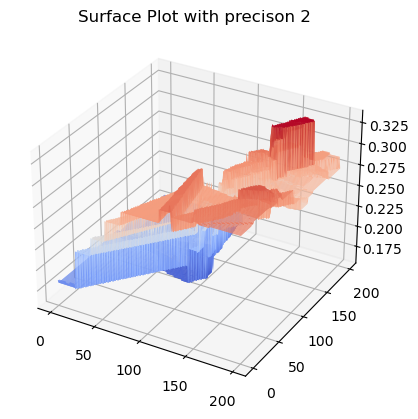

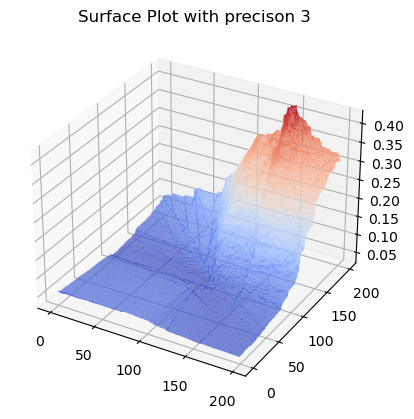

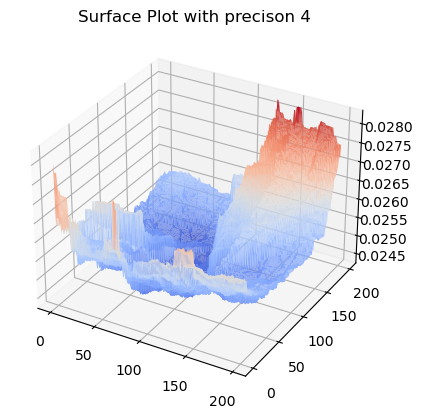

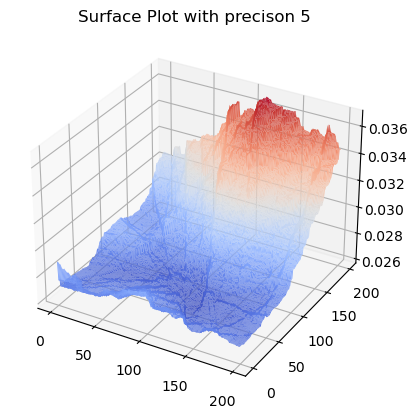

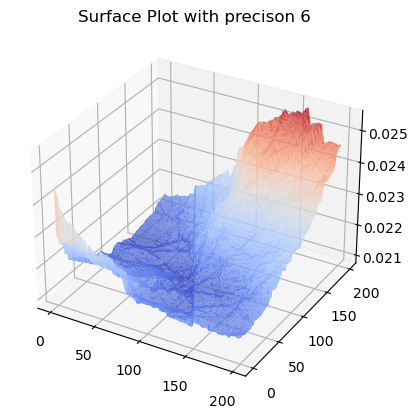

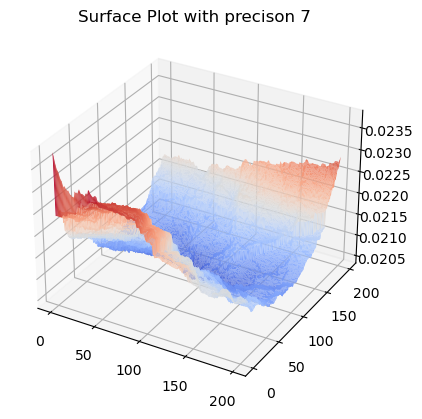

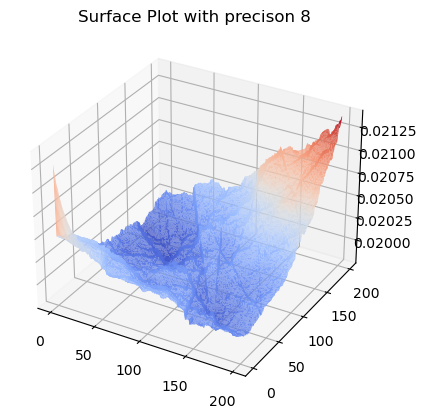

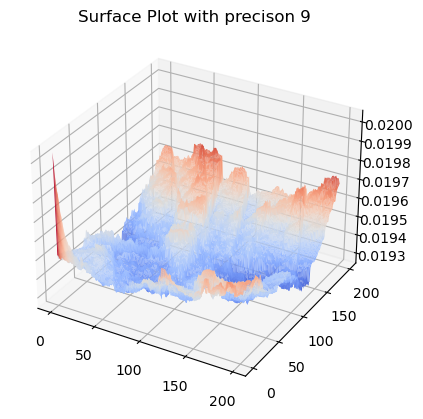

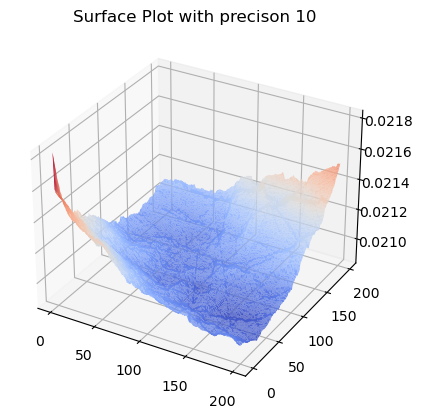

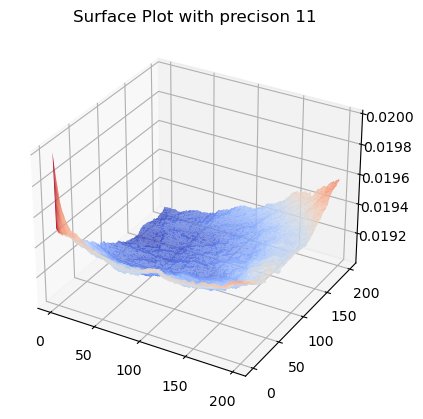

In [14]:
for p in precisions:
    data = get_loss_landscapes(BATCH_SIZE, LEARNING_RATE, p, 'baseline', NORMALIZATION, STEPS, DISTANCE)
    loss_data = data['points']    
    # #plot 3D
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
    Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
    ax.plot_surface(X, Y, loss_data, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
    ax.set_title(f'Surface Plot with precison {p}')
    fig.show()

# Features of the non-dominated solutions
We can see our task as Multi-Objective problems, indeed we have 3 objective function:

- we prefer models with higher accuracy;
- we prefer models with lower precision;
- we prefer models with higher robustness.

The idea is to evidence the non-dominated solutions of our analysis to check what are the characteristics of those kinds of models.

In [15]:
df = dataset_df[['precision', 'emd', 'noise 5%']].copy()

### Efficiebt set of our grid search

In [33]:
front = 0
while not df.empty:
    front += 1
    # compute non dominated solutions
    best_mask = paretoset(df, sense=['min', 'min', 'min'])
    ES_df = df[best_mask].copy()
    # update dataset
    dataset_df.loc[ES_df.index, "front"] = front
    # remove front from the population
    df = df.drop(ES_df.index)
    
FRONTS = 5

In [34]:
dataset_df[dataset_df['front'] <= FRONTS]

precision       emd  noise 5%  noise 10%  noise 15%  noise 20%  \
6            2  2.768796  2.607853   2.948684   3.290247   3.584121   
12           2  2.891344  2.885671   3.098429   3.340414   3.549937   
13           2  2.894219  2.910465   3.092760   3.291233   3.464756   
20           2  2.925020  2.922750   3.076152   3.262928   3.426664   
27           2  2.715291  2.543496   2.863617   3.183720   3.445405   
..         ...       ...       ...        ...        ...        ...   
426         10  1.183586  2.537155   3.452459   3.822819   3.981243   
447         11  1.120972  3.225034   3.688270   3.804184   3.845747   
459         11  1.132923  3.522740   3.943302   4.026758   4.039444   
460         11  1.123161  3.758025   3.925178   3.953398   3.956901   
461         11  1.127617  3.419863   3.819421   3.957435   4.023776   

     batch_size  learning_rate   avg_cka    avg_EF  net_efficiency  front  
6            16       0.001563  0.353357  0.002183        0.205131    2.0  
12           32       0.003125  0.322801  0.000183        0.166002    3.0  
13           32       0.001563  0.285849  0.000227        0.157010    4.0  
20           64       0.001563  0.236093  0.000012        0.126553    5.0  
27          128       0.001563  0.377684  0.017349        0.289450    1.0  
..          ...            ...       ...       ...             ...    ...  
426         256       0.001563  0.426039  0.027779        0.323377    5.0  
447          16       0.001563  0.291911  0.042476        0.390916    3.0  
459          64       0.006250  0.357054  0.016159        0.409418    5.0  
460          64       0.003125  0.333173  0.016204        0.399341    4.0  
461          64       0.001563  0.299656  0.029374        0.394470    4.0  

[71 rows x 12 columns]

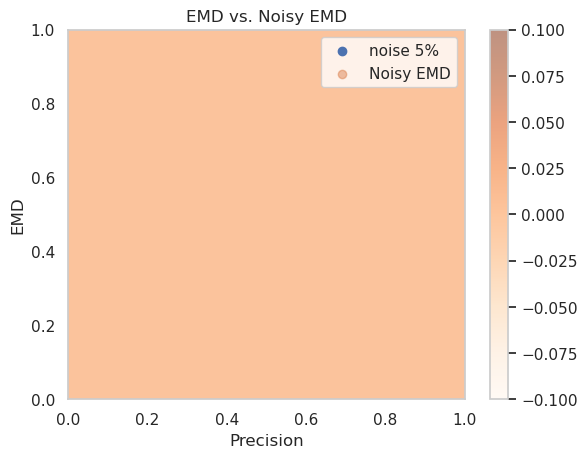

In [53]:
# Plot scatter plot for feature1 vs. cardinal
plt.scatter(df['precision'], df['emd'], label='noise 5%')

# Plot scatter plot for feature2 vs. cardinal with transparency
plt.scatter(df['precision'], df['noise 5%'], alpha=0.5, label='Noisy EMD')

# Add histograms to visualize the distribution at each point
plt.hist2d(df['precision'], df['emd'], bins=(20, 20), cmap='Blues', alpha=0.5)
plt.hist2d(df['precision'], df['noise 5%'], bins=(20, 20), cmap='Oranges', alpha=0.5)

plt.xlabel('Precision')
plt.ylabel('EMD')
plt.title('EMD vs. Noisy EMD')
plt.legend()
plt.colorbar()  # Show colorbar for histograms
plt.show()

### 2D plots

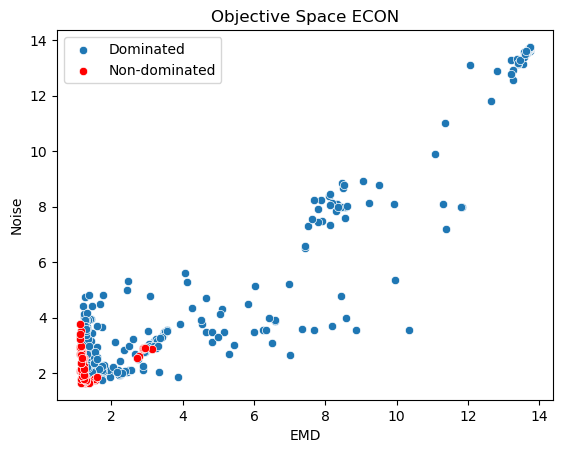

In [35]:
sns.scatterplot(x='emd', y='noise 5%', data=dataset_df, label='Dominated')
sns.scatterplot(x='emd', y='noise 5%', data=dataset_df[dataset_df['front'] <= FRONTS], color='red', label='Non-dominated')

plt.xlabel('EMD')
plt.ylabel('Noise')
plt.title(f'Objective Space ECON')

# Display the plot
plt.legend()
plt.show()

Let's try to plot them comparing the lerning rate with the neural efficiency due to their correlation.

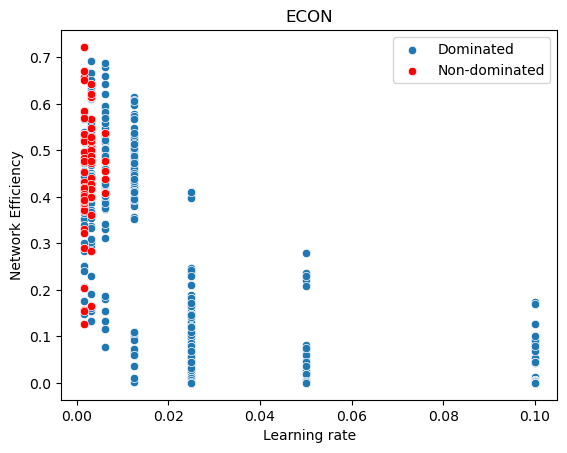

In [36]:
sns.scatterplot(y='net_efficiency', x='learning_rate', data=dataset_df, label='Dominated')
sns.scatterplot(y='net_efficiency', x='learning_rate', data=dataset_df[dataset_df['front'] <= FRONTS], color='red', label='Non-dominated')

plt.ylabel('Network Efficiency')
plt.xlabel('Learning rate')
plt.title(f'ECON')

# Display the plot
plt.legend()
plt.show()

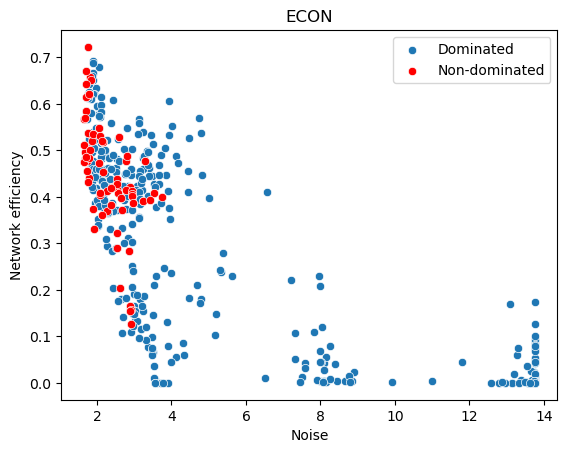

In [37]:
sns.scatterplot(x='noise 5%', y='net_efficiency', data=dataset_df, label='Dominated')
sns.scatterplot(x='noise 5%', y='net_efficiency', data=dataset_df[dataset_df['front'] <= FRONTS], color='red', label='Non-dominated')

plt.xlabel('Noise')
plt.ylabel('Network efficiency')
plt.title(f'ECON')

# Display the plot
plt.legend()
plt.show()

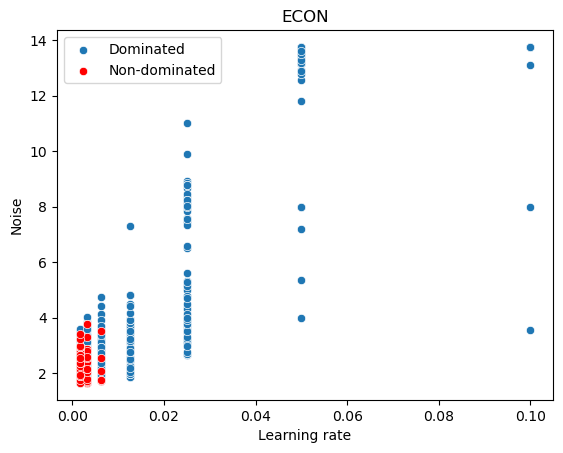

In [38]:
sns.scatterplot(y='noise 5%', x='learning_rate', data=dataset_df, label='Dominated')
sns.scatterplot(y='noise 5%', x='learning_rate', data=dataset_df[dataset_df['front'] <= FRONTS], color='red', label='Non-dominated')

plt.ylabel('Noise')
plt.xlabel('Learning rate')
plt.title(f'ECON')

# Display the plot
plt.legend()
plt.show()

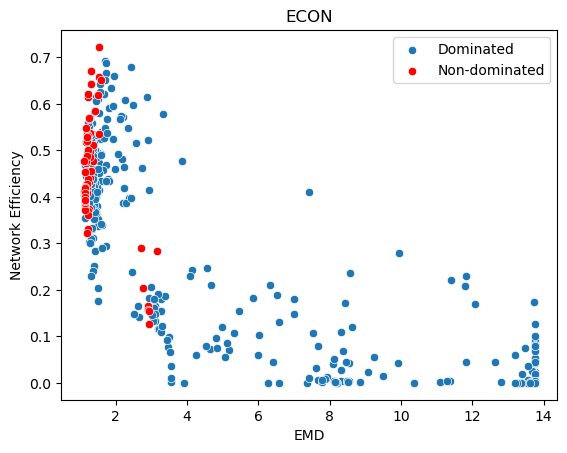

In [39]:
sns.scatterplot(y='net_efficiency', x='emd', data=dataset_df, label='Dominated')
sns.scatterplot(y='net_efficiency', x='emd', data=dataset_df[dataset_df['front'] <= FRONTS], color='red', label='Non-dominated')

plt.ylabel('Network Efficiency')
plt.xlabel('EMD')
plt.title(f'ECON')

# Display the plot
plt.legend()
plt.show()

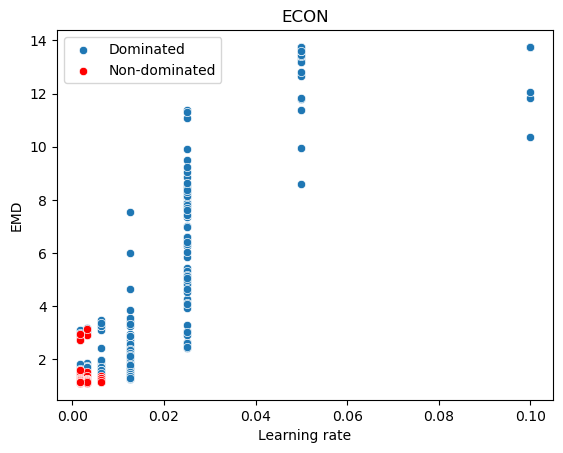

In [40]:
sns.scatterplot(x='learning_rate', y='emd', data=dataset_df, label='Dominated')
sns.scatterplot(x='learning_rate', y='emd', data=dataset_df[dataset_df['front'] <= FRONTS], color='red', label='Non-dominated')

plt.xlabel('Learning rate')
plt.ylabel('EMD')
plt.title(f'ECON')

# Display the plot
plt.legend()
plt.show()

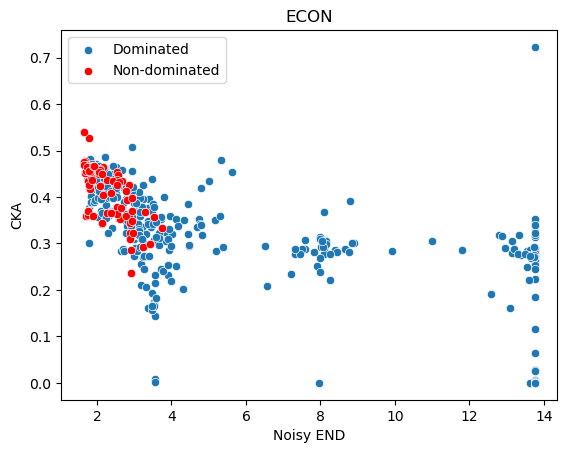

In [41]:
sns.scatterplot(y='avg_cka', x='noise 5%', data=dataset_df, label='Dominated')
sns.scatterplot(y='avg_cka', x='noise 5%', data=dataset_df[dataset_df['front'] <= FRONTS], color='red', label='Non-dominated')

plt.ylabel('CKA')
plt.xlabel('Noisy END')
plt.title(f'ECON')

# Display the plot
plt.legend()
plt.show()

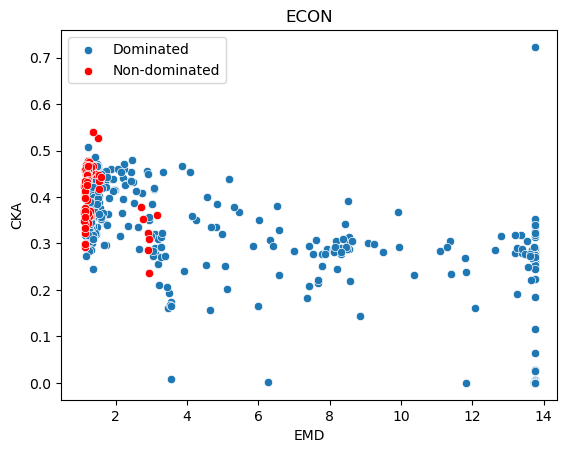

In [42]:
sns.scatterplot(y='avg_cka', x='emd', data=dataset_df, label='Dominated')
sns.scatterplot(y='avg_cka', x='emd', data=dataset_df[dataset_df['front'] <= FRONTS], color='red', label='Non-dominated')

plt.ylabel('CKA')
plt.xlabel('EMD')
plt.title(f'ECON')

# Display the plot
plt.legend()
plt.show()

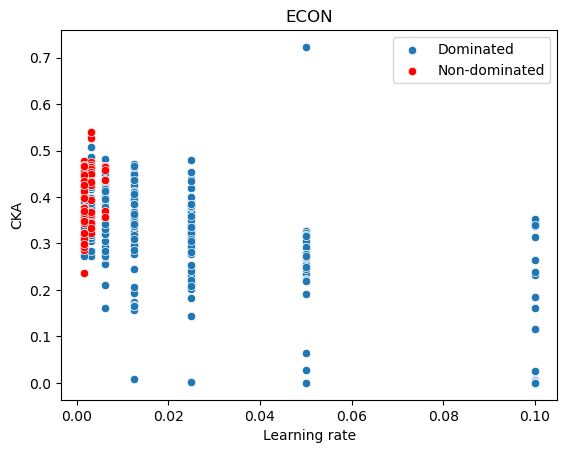

In [43]:
sns.scatterplot(y='avg_cka', x='learning_rate', data=dataset_df, label='Dominated')
sns.scatterplot(y='avg_cka', x='learning_rate', data=dataset_df[dataset_df['front'] <= FRONTS], color='red', label='Non-dominated')

plt.ylabel('CKA')
plt.xlabel('Learning rate')
plt.title(f'ECON')

# Display the plot
plt.legend()
plt.show()

### 3D plots

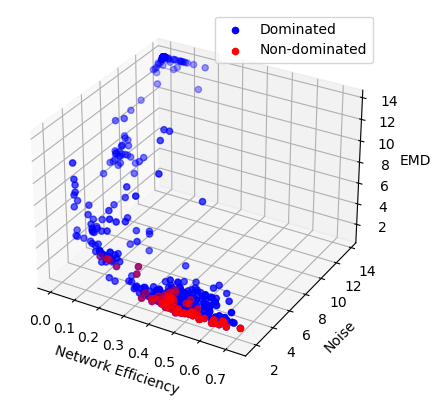

In [44]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot all points
ax.scatter(dataset_df['net_efficiency'], dataset_df['noise 5%'], dataset_df['emd'], c='blue', label='Dominated')

# Highlight points based on index
highlight_indices = dataset_df[dataset_df['front'] <= FRONTS].index
highlight_df = dataset_df.iloc[highlight_indices]
ax.scatter(highlight_df['net_efficiency'], highlight_df['noise 5%'], highlight_df['emd'], c='red', label='Non-dominated')

# Set labels
ax.set_xlabel('Network Efficiency')
ax.set_zlabel('EMD')
ax.set_ylabel('Noise')

# Add legend
plt.legend()

# Show plot
plt.show()

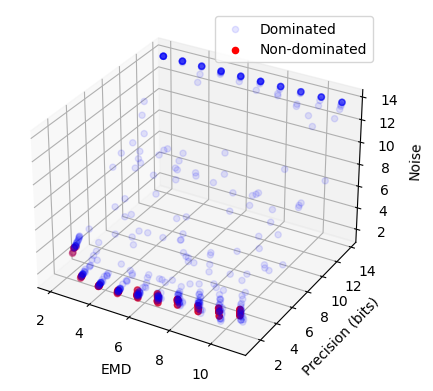

In [50]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot all points
ax.scatter(dataset_df['precision'], dataset_df['emd'], dataset_df['noise 5%'], c='blue', alpha=0.1, label='Dominated')

# Highlight points based on index
highlight_indices = dataset_df[dataset_df['front'] <= FRONTS].index
highlight_df = dataset_df.iloc[highlight_indices]
ax.scatter(highlight_df['precision'], highlight_df['emd'], highlight_df['noise 5%'], c='red', label='Non-dominated')

# Set labels
ax.set_xlabel('EMD')
ax.set_ylabel('Precision (bits)')
ax.set_zlabel('Noise')

# Add legend
plt.legend()

# Show plot
plt.show()

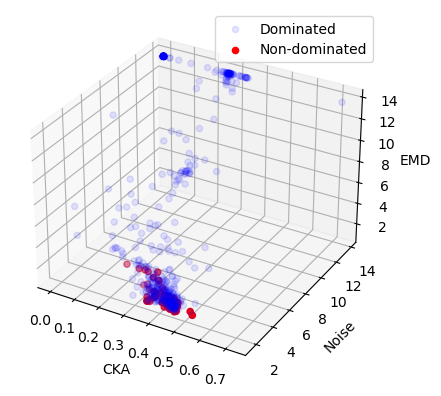

In [49]:
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot all points
ax.scatter(dataset_df['avg_cka'], dataset_df['noise 5%'], dataset_df['emd'], c='blue', alpha=0.1, label='Dominated')

# Highlight points based on index
highlight_indices = dataset_df[dataset_df['front'] <= FRONTS].index
highlight_df = dataset_df.iloc[highlight_indices]
ax.scatter(highlight_df['avg_cka'], highlight_df['noise 5%'], highlight_df['emd'], c='red', label='Non-dominated')

# Set labels
ax.set_xlabel('CKA')
ax.set_zlabel('EMD')
ax.set_ylabel('Noise')

# Add legend
plt.legend()

# Show plot
plt.show()

In [47]:
dataset_df[dataset_df['front'] == 1]

precision       emd  noise 5%  noise 10%  noise 15%  noise 20%  \
27           2  2.715291  2.543496   2.863617   3.183720   3.445405   
62           3  1.428586  1.714786   2.270176   2.754300   3.136089   
104          4  1.230677  1.675178   2.343803   2.838584   3.200978   
117          4  1.243314  1.660596   2.310483   2.772190   3.089334   
153          5  1.155972  1.649740   2.316256   2.786517   3.113371   
160          5  1.151243  1.792468   2.588295   3.104950   3.419019   
223          6  1.105781  2.092937   3.006155   3.534956   3.847934   
228          6  1.147033  2.082024   2.807577   3.183726   3.393645   
404         10  1.104643  3.295514   3.608166   3.627738   3.625013   

     batch_size  learning_rate   avg_cka    avg_EF  net_efficiency  front  
27          128       0.001563  0.377684  0.017349        0.289450    1.0  
62           32       0.001563  0.449556  0.000047        0.585544    1.0  
104          16       0.001563  0.476672  0.001337        0.482084    1.0  
117          64       0.003125  0.474515  0.000503        0.566857    1.0  
153          16       0.001563  0.469731  0.024354        0.475019    1.0  
160          32       0.001563  0.425706  0.013519        0.484760    1.0  
223         128       0.001563  0.423235  0.040602        0.403178    1.0  
228         256       0.006250  0.457194  0.014435        0.407676    1.0  
404          32       0.003125  0.368108  0.017068        0.476849    1.0